In [1]:
import mlp
import meta_poisoning_typical as mp

import jax
import jax.numpy as jnp
from flax import struct
from flax.training.train_state import TrainState
from jax.flatten_util import ravel_pytree
from optax import (
    softmax_cross_entropy as dense_xent,
    softmax_cross_entropy_with_integer_labels as sparse_xent
)
import optax
import numpy as np
from typing import Optional, Callable
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from tqdm import tqdm


/home/adam/.conda/envs/jax311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Defns

In [2]:
def make_split(X, Y, splits: list[int], key: jax.random.PRNGKey) -> list[tuple[jnp.ndarray, jnp.ndarray]]:
    if splits[-1] == -1:
        splits[-1] = len(X) - sum(splits[:-1])

    indices = jax.random.permutation(key, len(X))
    for split in splits:
        yield X[indices[:split]], Y[indices[:split]]
        indices = indices[split:]

def get_digits_splits(key: jax.random.PRNGKey, splits: list[int]) -> list[tuple[jnp.ndarray, jnp.ndarray]]:
    X, Y = load_digits(return_X_y=True)
    X = X / 16.0
    return make_split(X, Y, splits, key)

In [3]:
@struct.dataclass
class SimpleConfig:
    seed: int = 0

    batch_size: int = 64
    num_epochs: int = 25

    opt: str = "sgd"
    lr: float = 0.1
    train_size: int = 768
    num_layers: int = 1

    mesa_constrain: bool = False
    norm_scale: float = 1.0
    spherical: bool = True

In [4]:
def get_model(cfg: SimpleConfig, x):
    seed = cfg.seed
    key = jax.random.key(seed)

    d_inner = x.shape[1]

    model = mlp.MLP(hidden_sizes=(d_inner,) * cfg.num_layers, 
                out_features=10, 
                norm_scale=cfg.norm_scale, 
                spherical=cfg.spherical)
    
    params = mlp.Params(model.init(key, x))  # this will already be close to the ellipsoid

    return model, params

In [5]:

def make_apply_full(model, unraveler):
    """Make an apply function that takes the full parameter vector."""
    def apply_full(raveled, x):
        params = unraveler(raveled)
        return model.apply(params, x)
    
    return apply_full

def compute_loss(params, apply_fn, X, Y):
    logits = apply_fn(params['p'], X)
    preds = jnp.argmax(logits, axis=-1)

    loss = sparse_xent(logits, Y).mean()
    acc = jnp.mean(preds == Y)
    return loss, acc

def train_simple(
    params_raveled, unravel: Callable, digits_splits, apply_fn, cfg: SimpleConfig,
    target_norm: Optional[float] = None, return_state: bool = False,
):
    x_train, y_train = digits_splits[0]
    x_test, y_test = digits_splits[1]
    x_shape = x_train[0].shape
    x_train, y_train = jnp.array(x_train), jnp.array(y_train)

    # LR schedule
    num_steps = cfg.num_epochs * len(x_train) // cfg.batch_size

    # Define the optimizer and training state
    if cfg.opt == "adam":
        sched = optax.cosine_decay_schedule(cfg.lr, num_steps)
        tx = optax.adam(learning_rate=sched, eps_root=1e-8)
    else:
        sched = optax.cosine_decay_schedule(cfg.lr, num_steps)
        tx = optax.sgd(learning_rate=sched, momentum=0.9)

    if target_norm is not None:
        params_raveled = params_raveled * target_norm / mlp.ellipsoid_norm(mlp.Params(params_raveled, unravel), cfg.spherical)
    elif cfg.mesa_constrain:
        target_norm = mlp.ellipsoid_norm(mlp.Params(params_raveled, unravel), cfg.spherical)

    state = TrainState.create(apply_fn=apply_fn, params=dict(p=params_raveled), tx=tx)

    # Forward and backward pass
    loss_and_grad = jax.value_and_grad(compute_loss, has_aux=True)

    # RNG key for each epoch
    keys = jax.vmap(jax.random.key)(jnp.arange(cfg.num_epochs))

    def train_step(state: TrainState, batch):
        loss, grads = loss_and_grad(state.params, state.apply_fn, *batch)
        state = state.apply_gradients(grads=grads)
        if target_norm is not None:
            state.params['p'] *= target_norm / mlp.ellipsoid_norm(mlp.Params(state.params['p'], unravel), cfg.spherical)
        return state, loss

    def epoch_step(state: TrainState, key) -> tuple[TrainState, tuple[jnp.ndarray, jnp.ndarray]]:
        # Re-shuffle the data at the start of each epoch
        indices = jax.random.permutation(key, len(x_train))
        x_train_, y_train_ = x_train[indices], y_train[indices]

        # Create the batches
        x_train_batches = jnp.reshape(x_train_, (-1, cfg.batch_size, *x_shape))
        y_train_batches = jnp.reshape(y_train_, (-1, cfg.batch_size))
        
        state, (losses, accs) = jax.lax.scan(train_step, state, (x_train_batches, y_train_batches))
        return state, (losses.mean(), accs.mean())

    state, (train_loss, _) = jax.lax.scan(epoch_step, state, keys)

    # Test loss
    logits = state.apply_fn(state.params['p'], x_test)
    test_loss = sparse_xent(logits, y_test).mean()

    if return_state:
        return test_loss, train_loss[-1], state
    return test_loss, train_loss[-1]


In [6]:
def find_radius(center, vec, cutoff, fn, rtol=1e-1, high=None, low=0, init_mult=1, iters=10, jump=2.0):
    center_loss = fn(center)
    vec_loss = fn(center + init_mult * vec)

    if iters == 0 or jnp.abs(vec_loss - center_loss - cutoff) < cutoff * rtol:
        return init_mult, vec_loss - center_loss
    if vec_loss - center_loss < cutoff:  # too low  
        low = init_mult
        if high is None:
            new_init_mult = init_mult * jump
        else:
            new_init_mult = (high + low) / 2
    else:  # too high
        high = init_mult
        new_init_mult = (high + low) / 2
    
    return find_radius(center, vec, cutoff, fn=fn, high=high, low=low, init_mult=new_init_mult, iters=iters - 1)

In [7]:
def logspace(start, end, num):
    return 10**jnp.linspace(jnp.log10(start), jnp.log10(end), num)

In [8]:
def logspace_indices(length, num):
    # logarithically spaced indices from each end towards the middle
    num_beginning = num // 2 + 1
    num_end = num - num_beginning
    beginning = logspace(1, length // 2 + 1, num_beginning)
    beginning -= 1
    end = length - logspace(1, (length - length // 2) + 1, num_end + 1)
    end = end[-2::-1]
    return jnp.concatenate([beginning, end]).astype(int)    

In [136]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy import stats

def normal_probability_plot(data, figsize=(10, 6), title="Normal Probability Plot"):
    """
    Create a normal probability plot for the given data.
    
    Parameters:
    - data: JAX array or list of data points
    - figsize: tuple, size of the figure (width, height)
    - title: str, title of the plot
    
    Returns:
    - fig, ax: matplotlib figure and axis objects
    """
    # Convert to JAX array if it's not already
    if not isinstance(data, jnp.ndarray):
        data = jnp.array(data)
    
    # Normalize the data
    normalized_data = (data - jnp.mean(data)) / jnp.std(data)
    
    # Sort the normalized data
    sorted_data = jnp.sort(normalized_data)
    
    # Calculate theoretical quantiles
    n = len(sorted_data)
    theoretical_quantiles = stats.norm.ppf((jnp.arange(1, n+1) - 0.5) / n)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the points
    ax.scatter(theoretical_quantiles, sorted_data, alpha=0.5)
    
    # Plot the line y=x
    ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")
    
    # Set labels and title
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Sample Quantiles (Normalized)")
    ax.set_title(title)
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    return fig, ax

# Example usage:
# fig, ax = normal_probability_plot(estimates_100k)
# plt.show()

# Common

In [9]:
cfg = SimpleConfig(train_size=1024, opt="adam", lr=.06)

In [10]:
digits_splits = list(get_digits_splits(jax.random.key(cfg.seed), [cfg.train_size, -1]))
X_train, Y_train = digits_splits[0]
X_test, Y_test = digits_splits[1]
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

2024-10-09 19:31:09.094668: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.6.68. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


((1024, 64), (1024,), (773, 64), (773,))

In [11]:
model, init_params = get_model(cfg, X_train)

apply_fn = make_apply_full(model, init_params.unravel)

In [12]:
def quick_train():
    return train_simple(init_params.raveled, init_params.unravel, digits_splits, apply_fn, cfg, return_state=True)

In [13]:
test_loss, train_loss, state = quick_train()

In [14]:
final_params = mlp.Params(state.params['p'], init_params.unravel)

# Experiments

## Basin volume

In [15]:
def logvol_estimate(params, fn, key):
    center = params.raveled
    vec = jax.random.normal(key, center.shape)
    vec = vec / jnp.linalg.norm(vec)
    rad, delta = find_radius(center, vec, cutoff=1e-3, fn=fn, iters=100, rtol=1e-2)
    return center.shape[0] * jnp.log(rad), delta

In [16]:
def aggregate(estimates):
    return jax.scipy.special.logsumexp(jnp.array(estimates), b=1/len(estimates))

In [17]:
def loss_fn(params_raveled):
    loss, acc = compute_loss({'p': params_raveled}, apply_fn, X_train, Y_train)
    return loss

In [18]:
loss_fn(final_params.raveled)

Array(0.0008017, dtype=float32)

In [19]:
def get_estimates(n):
    keys = jax.random.split(jax.random.key(cfg.seed), n)

    estimates = []
    diffs = []

    for key in tqdm(keys):
        est, diff = logvol_estimate(final_params, loss_fn, key)
        estimates.append(est)
        diffs.append(diff)
    estimates = jnp.array(estimates)
    diffs = jnp.array(diffs)

    return estimates, diffs

In [24]:
estimates_300, diffs_300 = get_estimates(300)

100%|██████████| 300/300 [00:32<00:00,  9.28it/s]


In [20]:
estimates, diffs = get_estimates(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:36<00:00, 10.41it/s]


### Plots etc

In [ ]:
print(aggregate(jnp.array([100, 200, 300])))
print(aggregate(jnp.array([10, 20, 30])))
print(aggregate(jnp.array([1, 2, 3])))

298.9014
28.901434
2.3089938


(3162,) (3162,)
0.00090026023 0.0010998468


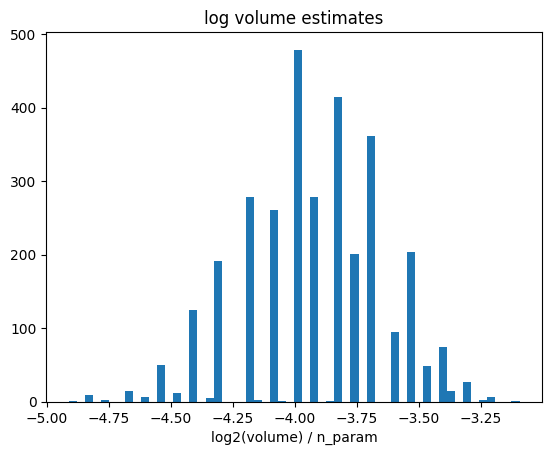

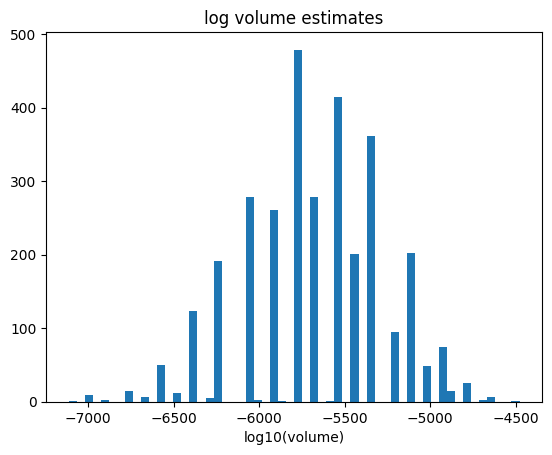

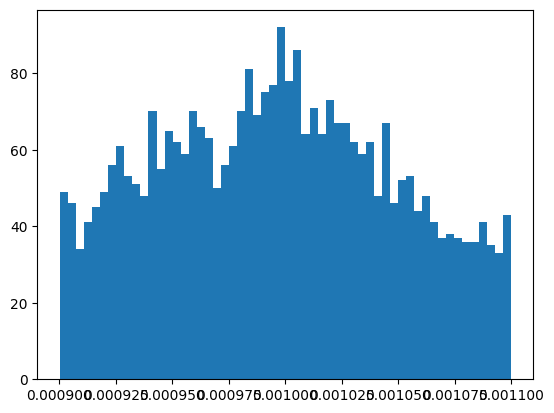

In [284]:

print(estimates.shape, diffs.shape)
print(diffs.min(), diffs.max())

n = int(10**(3.5))
param_dim = final_params.raveled.shape[0]

plt.hist(estimates / param_dim / jnp.log(2), bins=int(jnp.sqrt(n)))
plt.title('log volume estimates')
plt.xlabel('log2(volume) / n_param')
plt.show()
plt.hist(estimates / jnp.log(10), bins=int(jnp.sqrt(n)))
plt.title('log volume estimates')
plt.xlabel('log10(volume)')
plt.show()
plt.hist(diffs, bins=int(jnp.sqrt(n)))
plt.show()


In [158]:
unique = {float(x) for x in estimates}
unique = jnp.array(list(unique))
unique = jnp.sort(unique)

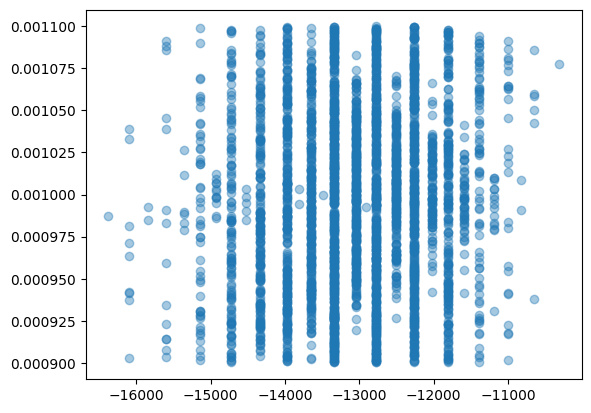

In [291]:
plt.scatter(estimates, diffs, alpha=0.4)
plt.show()

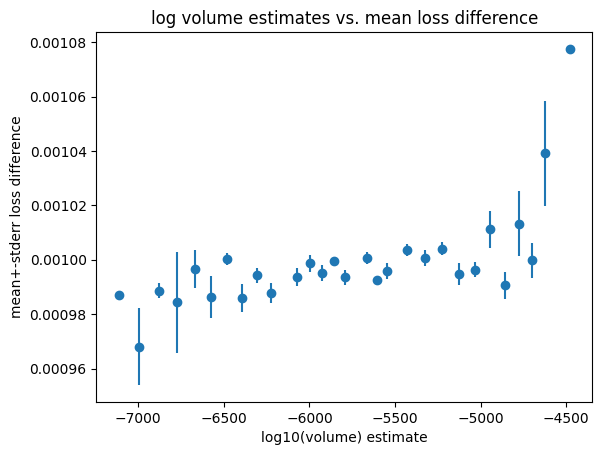

In [293]:
#plt.scatter(unique / jnp.log(10), [jnp.log10(diffs[estimates==x].mean()) for x in unique])
# error bars for std
diff_batches = [diffs[estimates==x] for x in unique]
plt.errorbar(unique / jnp.log(10), 
             [x.mean() for x in diff_batches], 
             yerr=[x.std() / jnp.sqrt(len(x)) for x in diff_batches],
             fmt='o')
plt.title('log volume estimates vs. mean loss difference')
plt.xlabel('log10(volume) estimate')
plt.ylabel('mean+-stderr loss difference')
plt.show()

In [123]:
# 3162
jnp.mean(estimates), jnp.max(estimates), jnp.min(estimates), aggregate(estimates)

(Array(-13071.879, dtype=float32),
 Array(-10312.544, dtype=float32),
 Array(-16378.585, dtype=float32),
 Array(-10320.603, dtype=float32))

In [124]:
estimates[jnp.argsort(estimates)[-10:]] / jnp.log(10), aggregate(estimates) / jnp.log(10)

(Array([-4777.613 , -4698.7744, -4698.7744, -4622.804 , -4622.804 ,
        -4622.804 , -4622.804 , -4622.804 , -4622.804 , -4478.681 ],      dtype=float32),
 Array(-4482.1807, dtype=float32))

In [140]:
(estimates_300 < -12000).sum()

Array(269, dtype=int32)

In [141]:
(estimates < -12000).sum()

Array(2787, dtype=int32)

In [135]:
# 300
jnp.mean(estimates_300), jnp.max(estimates_300), jnp.min(estimates_300), aggregate(estimates_300)

(Array(-13114.638, dtype=float32),
 Array(-10312.544, dtype=float32),
 Array(-15596.869, dtype=float32),
 Array(-10318.248, dtype=float32))

In [138]:
jnp.sort(estimates_300)[-10:] / jnp.log(10), aggregate(estimates_300) / jnp.log(10)

(Array([-4944.8184, -4944.8184, -4944.8184, -4944.8184, -4777.613 ,
        -4777.613 , -4777.613 , -4777.613 , -4622.804 , -4478.681 ],      dtype=float32),
 Array(-4481.158, dtype=float32))

In [323]:
# 300
jnp.mean(estimates_300), jnp.max(estimates_300), jnp.min(estimates_300), aggregate(estimates_300)

(Array(7284.962, dtype=float32),
 Array(10002.114, dtype=float32),
 Array(4865.801, dtype=float32),
 Array(9996.41, dtype=float32))

In [325]:
jnp.sort(estimates_300)[-10:] / jnp.log(10), aggregate(estimates_300) / jnp.log(10)

(Array([3910.1133, 3910.1133, 3910.1133, 3910.1133, 3988.9512, 4064.9219,
        4064.9219, 4064.9219, 4209.045 , 4343.8633], dtype=float32),
 Array(4341.3857, dtype=float32))

## making Hessian preconditioner

In [20]:
H = jax.hessian(loss_fn)(final_params.raveled)

In [169]:
eigvals = jnp.linalg.eigvalsh(H)

In [114]:
evals, evecs = jnp.linalg.eigh(H)
# evals: [n]
# evecs: [n, n]
# top eigenvector is evecs[:, -1]

In [97]:
p = 1 / (jnp.sqrt(jnp.abs(evals)) + 1e-3)
logp = jnp.log(p)
logp_norm = logp - jnp.mean(logp)
p = jnp.exp(logp_norm)
P = jnp.einsum('ij,j->ij', evecs, p)

In [105]:
P_spec = P / jnp.exp(jnp.linalg.slogdet(P).logabsdet / evecs.shape[0])

#### Unit det, etc

In [ ]:
logdetevecs = jnp.linalg.slogdet(evecs).logabsdet
evecs_norm = evecs / jnp.exp(logdetevecs / evecs.shape[0])
P_special = jnp.einsum('ij,j->ij', evecs_norm, p)

In [106]:
jnp.linalg.slogdet(P_special), jnp.linalg.slogdet(P_spec)

(SlogdetResult(sign=Array(-1., dtype=float32), logabsdet=Array(-0.0007019, dtype=float32)),
 SlogdetResult(sign=Array(-1., dtype=float32), logabsdet=Array(-0.00012207, dtype=float32)))

In [ ]:
jnp.linalg.norm(H - jnp.einsum('ij,j,jk->ik', evecs, evals, evecs.T))

Array(3.6562447e-05, dtype=float32)

### Spectrum scan

In [ ]:
center = final_params.raveled

idx = logspace_indices(eigvals.shape[0], 200)
rads = []
rads_neg = []
deltas = []
for i in tqdm(idx):
    vec = evecs[:, i]
    rad, delta = find_radius(center, vec, cutoff=1e-3, fn=loss_fn, iters=100, rtol=1e-2)
    rad_neg, delta_neg = find_radius(center, -vec, cutoff=1e-3, fn=loss_fn, iters=100, rtol=1e-2)
    rads.append(rad)
    rads_neg.append(rad_neg)
    deltas.append(delta)
    deltas.append(delta_neg)
rads = jnp.array(rads)
rads_neg = jnp.array(rads_neg)
deltas = jnp.array(deltas)

100%|██████████| 200/200 [00:45<00:00,  4.38it/s]


### Plots etc

In [ ]:
jnp.linalg.slogdet(evecs), jnp.linalg.slogdet(H), jnp.linalg.slogdet(P)

(SlogdetResult(sign=Array(-1., dtype=float32), logabsdet=Array(11.844833, dtype=float32)),
 SlogdetResult(sign=Array(0., dtype=float32), logabsdet=Array(-inf, dtype=float32)),
 SlogdetResult(sign=Array(-1., dtype=float32), logabsdet=Array(11.844204, dtype=float32)))

In [ ]:
11.844 / jnp.log(10)

Array(5.143784, dtype=float32, weak_type=True)

In [ ]:
logp_norm.min(), logp_norm.max(), logp_norm.mean(), logp_norm.std()

(Array(-4.9930286, dtype=float32),
 Array(0.658062, dtype=float32),
 Array(-1.3482298e-07, dtype=float32),
 Array(0.83437836, dtype=float32))

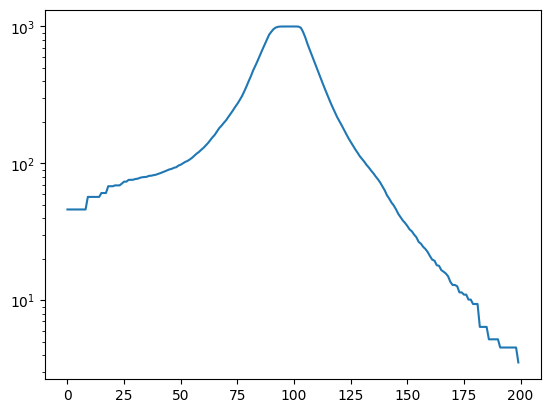

In [ ]:

plt.plot(p[idx])
plt.yscale('log')
plt.show()

In [ ]:
(eigvals == evals).all()

Array(True, dtype=bool)

(4810,)
-0.00042893144 0.080429934
2154


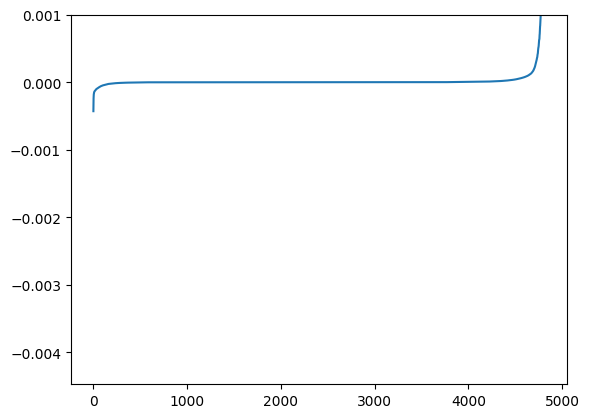

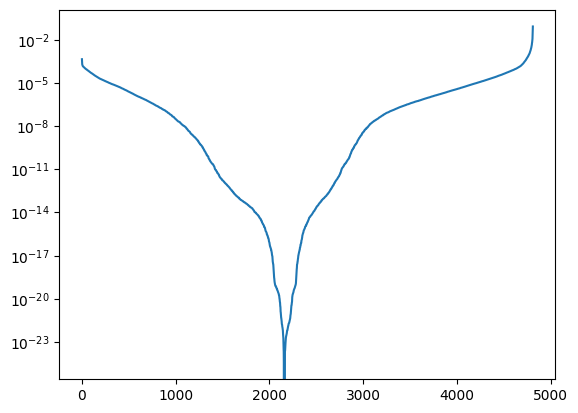

In [ ]:

print(eigvals.shape)
print(eigvals.min(), eigvals.max())
print((eigvals < 0).sum())

plt.plot(eigvals)
plt.ylim(top=.001)
plt.show()
plt.plot(jnp.abs(eigvals))
plt.yscale('log')
plt.show()


In [ ]:
jnp.min(deltas), jnp.max(deltas)

(Array(0.00090128, dtype=float32), Array(0.00109973, dtype=float32))

In [ ]:
param_dim

4810

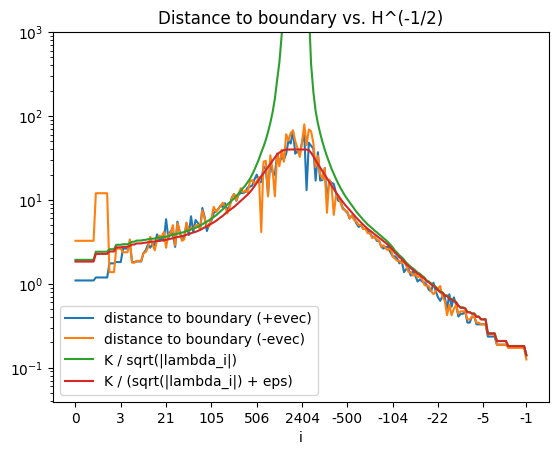

In [ ]:
eps = 1e-6

rat = rads[-1] * jnp.sqrt(jnp.abs(eigvals[-1]))

plt.plot(rads, label='distance to boundary (+evec)')
plt.plot(rads_neg, label='distance to boundary (-evec)')
plt.plot(rat/jnp.sqrt(jnp.abs(eigvals[idx])), label = 'K / sqrt(|lambda_i|)')
plt.plot(rat/(jnp.sqrt(eps) + jnp.sqrt(jnp.abs(eigvals[idx]))), label = 'K / (sqrt(|lambda_i|) + eps)')
plt.yscale('log')
plt.ylim(top=1e3)
plt.legend()
plt.title('Distance to boundary vs. H^(-1/2)')
plt.xlabel('i')
# change x labels to idx
tick_spacing = 20
plt.xticks(list(range(0, len(idx), tick_spacing)) + [len(idx) - 1], 
           [(f'{i - param_dim}' if i > param_dim//2 else f'{i}') 
            for i in idx[::tick_spacing]] + [f'{idx[-1] - param_dim}'])
plt.show()

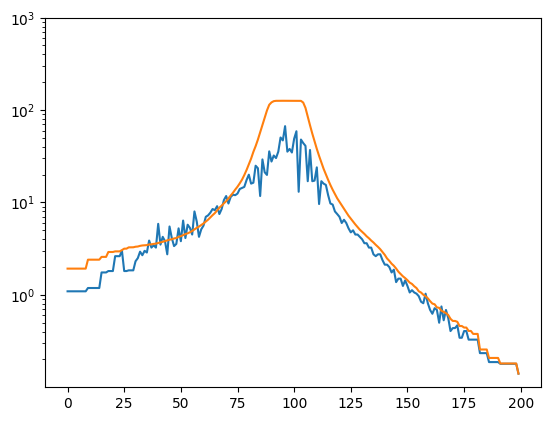

In [ ]:
eps = 1e-7
rat = rads[-1] * jnp.sqrt(jnp.abs(eigvals[-1]))

plt.plot(rads)
plt.plot(rat/jnp.sqrt(eps + jnp.abs(eigvals[idx])))
plt.yscale('log')
plt.ylim(top=1e3)
plt.show()

## Preconditioned

In [39]:
def logvol_estimate_preconditioned(params, fn, key, preconditioner):
    center = params.raveled
    vec = jax.random.normal(key, center.shape)
    vec = vec / jnp.linalg.norm(vec)
    vec = preconditioner @ vec
    rad, delta = find_radius(center, vec, cutoff=1e-3, fn=fn, iters=100, rtol=1e-2)
    return center.shape[0] * jnp.log(rad), delta

In [146]:
def get_estimates_preconditioned(n, preconditioner, show_progress=True):
    keys = jax.random.split(jax.random.key(cfg.seed), n)

    estimates = []
    diffs = []
    if show_progress:
        keys = tqdm(keys)
    else:
        keys = keys

    for key in keys:
        est, diff = logvol_estimate_preconditioned(final_params, loss_fn, key, preconditioner)
        estimates.append(est)
        diffs.append(diff)
    estimates = jnp.array(estimates)
    diffs = jnp.array(diffs)

    return estimates, diffs

In [42]:
estimates_300, diffs_300 = get_estimates(300)

100%|██████████| 300/300 [00:29<00:00, 10.29it/s]


In [107]:
estimates_300_pre, diffs_300_pre = get_estimates_preconditioned(300, P_spec)

100%|██████████| 300/300 [00:47<00:00,  6.32it/s]


In [79]:
center = final_params.raveled

idx = logspace_indices(evals.shape[0], 200)
rads = []
rads_neg = []
deltas = []
for i in tqdm(idx):
    vec = P[:, i]
    rad, delta = find_radius(center, vec, cutoff=1e-3, fn=loss_fn, iters=100, rtol=1e-2)
    rad_neg, delta_neg = find_radius(center, -vec, cutoff=1e-3, fn=loss_fn, iters=100, rtol=1e-2)
    rads.append(rad)
    rads_neg.append(rad_neg)
    deltas.append(delta)
    deltas.append(delta_neg)
rads = jnp.array(rads)
rads_neg = jnp.array(rads_neg)
deltas = jnp.array(deltas)

100%|██████████| 200/200 [00:54<00:00,  3.67it/s]


### Bad preconditioner

In [86]:
diagH = jnp.diag(H)
p = 1 / (jnp.sqrt(jnp.abs(diagH)) + 1e-3)
logp = jnp.log(p)
logp_norm = logp - jnp.mean(logp)
p = jnp.exp(logp_norm)
P_diagH = jnp.diag(p)

In [88]:
results_300_diagH = get_estimates_preconditioned(300, P_diagH)

100%|██████████| 300/300 [00:38<00:00,  7.77it/s]


In [157]:
def scaled_preconditioner(scale=0.5, eps=1e-3):
    p = 1 / ((jnp.abs(evals))**scale + eps)
    logp = jnp.log(p)
    logp_norm = logp - jnp.mean(logp)
    p = jnp.exp(logp_norm)
    P_weak = jnp.einsum('ij,j->ij', evecs, p)

    P_weak = P_weak / jnp.exp(jnp.linalg.slogdet(P_weak).logabsdet / P_weak.shape[0])
    return P_weak

In [135]:
results_300_weak = get_estimates_preconditioned(300, scaled_preconditioner(0.25))

100%|██████████| 300/300 [00:46<00:00,  6.47it/s]


In [141]:
results_300_scale40 = get_estimates_preconditioned(300, scaled_preconditioner(0.4))

100%|██████████| 300/300 [00:48<00:00,  6.19it/s]


In [142]:
results_300_scale60 = get_estimates_preconditioned(300, scaled_preconditioner(0.6))

100%|██████████| 300/300 [00:38<00:00,  7.76it/s]


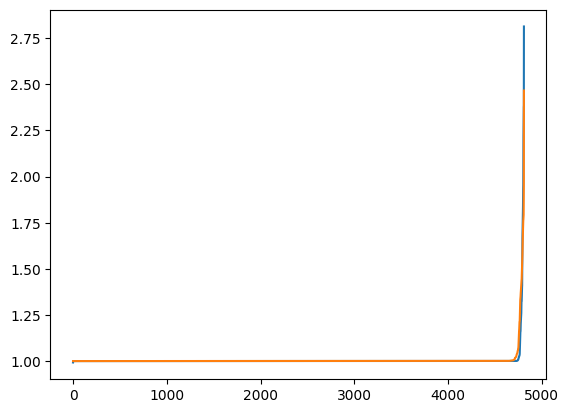

In [115]:
plt.plot(jnp.sort(jnp.linalg.norm(evecs, axis=0)))
plt.plot(jnp.sort(jnp.linalg.norm(evecs.T, axis=0)))
#plt.yscale('log')
plt.show()

### Plots etc

In [145]:
all_results = []
for scale in tqdm(logspace(0.25, 1.0, 11)):
    results = get_estimates_preconditioned(300, scaled_preconditioner(scale), show_progress=False)
    all_results.append(results)
all_results = jnp.array(all_results)

100%|██████████| 11/11 [07:42<00:00, 42.05s/it]


In [158]:
all_results_eps = []
for eps in tqdm(logspace(1e-6, 1, 11)):
    results = get_estimates_preconditioned(300, scaled_preconditioner(0.5, eps), show_progress=False)
    all_results_eps.append(results)
all_results_eps = jnp.array(all_results_eps)

100%|██████████| 11/11 [06:39<00:00, 36.34s/it]


In [149]:
aggregate(all_results[0][0])

Array(13020.018, dtype=float32)

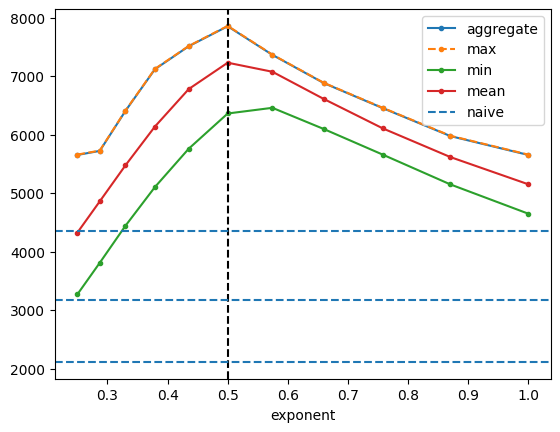

In [163]:
nbins = int(jnp.sqrt(300))
scales = logspace(0.25, 1.0, 11)
all_estimates_10 = all_results[:, 0] / jnp.log(10)
aggregates = jnp.array([aggregate(results) for results in all_estimates_10])
maxes = jnp.array([jnp.max(results) for results in all_estimates_10])
mins = jnp.array([jnp.min(results) for results in all_estimates_10])
means = jnp.array([jnp.mean(results) for results in all_estimates_10])
plt.plot(scales, aggregates, '.-', label='aggregate')
plt.plot(scales, maxes, '.--', label='max')
plt.plot(scales, mins, '.-', label='min')
plt.plot(scales, means, '.-', label='mean')
plt.axvline(0.5, color='black', linestyle='--')
plt.axhline(jnp.min(estimates_300) / jnp.log(10), linestyle='--', label='naive')
plt.axhline(jnp.max(estimates_300) / jnp.log(10), linestyle='--')
plt.axhline(jnp.mean(estimates_300) / jnp.log(10), linestyle='--')
plt.legend()
plt.xlabel('exponent')
plt.show()

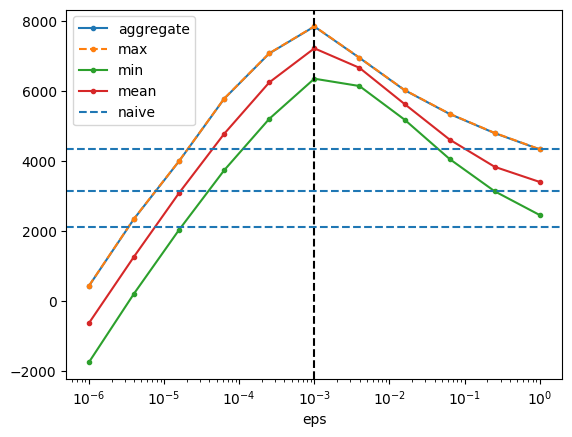

In [165]:
nbins = int(jnp.sqrt(300))
epses = logspace(1e-6, 1, 11)
all_estimates_10 = all_results_eps[:, 0] / jnp.log(10)
aggregates = jnp.array([aggregate(results) for results in all_estimates_10])
maxes = jnp.array([jnp.max(results) for results in all_estimates_10])
mins = jnp.array([jnp.min(results) for results in all_estimates_10])
means = jnp.array([jnp.mean(results) for results in all_estimates_10])
plt.plot(epses, aggregates, '.-', label='aggregate')
plt.plot(epses, maxes, '.--', label='max')
plt.plot(epses, mins, '.-', label='min')
plt.plot(epses, means, '.-', label='mean')
plt.axvline(1e-3, color='black', linestyle='--')
plt.axhline(jnp.min(estimates_300) / jnp.log(10), linestyle='--', label='naive')
plt.axhline(jnp.max(estimates_300) / jnp.log(10), linestyle='--')
plt.axhline(jnp.mean(estimates_300) / jnp.log(10), linestyle='--')
plt.legend()
plt.xscale('log')
plt.xlabel('eps')
plt.show()

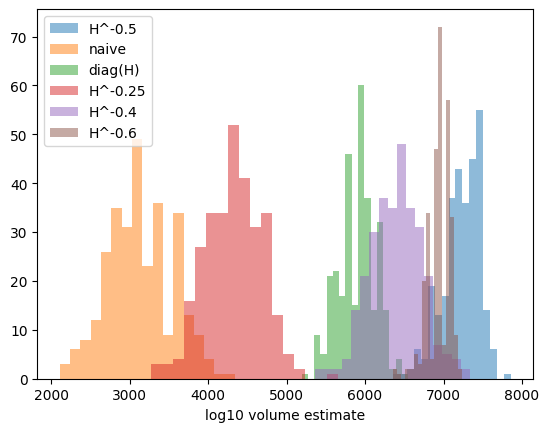

In [144]:
nbins = int(jnp.sqrt(300))
plt.hist(estimates_300_pre / jnp.log(10), bins=nbins, alpha=0.5, label="H^-0.5")
plt.hist(estimates_300 / jnp.log(10), bins=nbins, alpha=0.5, label="naive")
plt.hist(results_300_diagH[0] / jnp.log(10), bins=nbins, alpha=0.5, label="diag(H)")
plt.hist(results_300_weak[0] / jnp.log(10), bins=nbins, alpha=0.5, label="H^-0.25")
plt.hist(results_300_scale40[0] / jnp.log(10), bins=nbins, alpha=0.5, label="H^-0.4")
plt.hist(results_300_scale60[0] / jnp.log(10), bins=nbins, alpha=0.5, label="H^-0.6")
plt.xlabel("log10 volume estimate")
plt.legend()
plt.show()

In [30]:
estimates_100k = jnp.load('estimates_100000.npy')
diffs_100k = jnp.load('diffs_100000.npy')
estimates_100k_pre = jnp.load('estimates_preconditioned_100000.npy')
diffs_100k_pre = jnp.load('diffs_preconditioned_100000.npy')

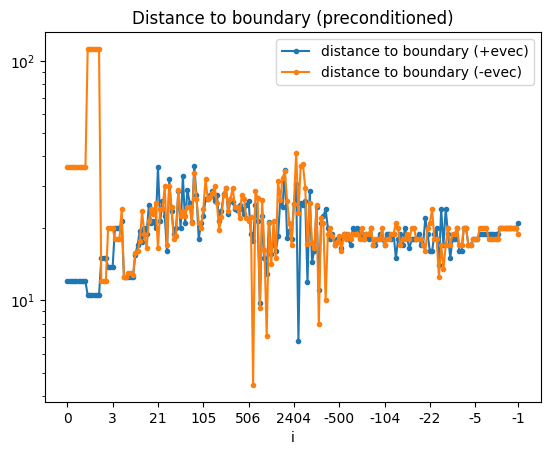

In [82]:
param_dim = final_params.raveled.shape[0]
plt.plot(rads, '.-', label='distance to boundary (+evec)')
plt.plot(rads_neg, '.-', label='distance to boundary (-evec)')
plt.yscale('log')
# plt.ylim(top=1e3)
plt.legend()
plt.title('Distance to boundary (preconditioned)')
plt.xlabel('i')
# change x labels to idx
tick_spacing = 20
plt.xticks(list(range(0, len(idx), tick_spacing)) + [len(idx) - 1], 
           [(f'{i - param_dim}' if i > param_dim//2 else f'{i}') 
            for i in idx[::tick_spacing]] + [f'{idx[-1] - param_dim}'])
plt.show()

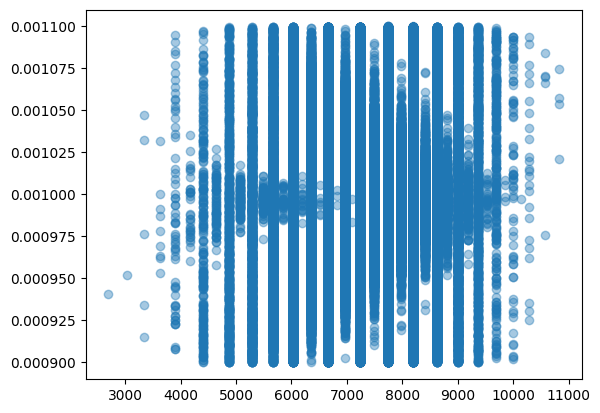

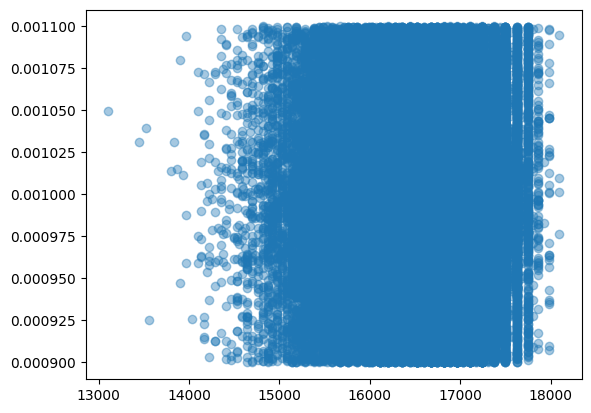

In [32]:
plt.scatter(estimates_100k, diffs_100k, alpha=0.4)
plt.show()
plt.scatter(estimates_100k_pre, diffs_100k_pre, alpha=0.4)
plt.show()

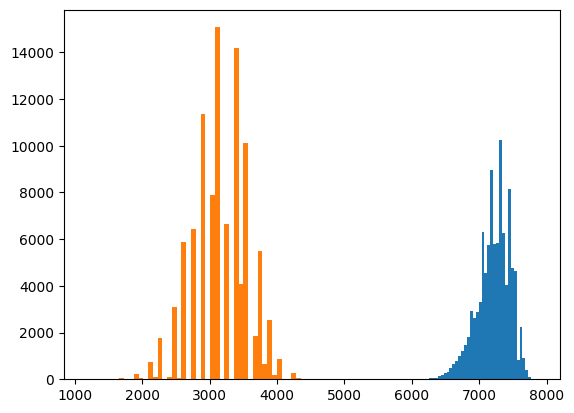

In [37]:
plt.hist(estimates_100k_pre / jnp.log(10), bins=50)
plt.hist(estimates_100k / jnp.log(10), bins=50)
plt.show()

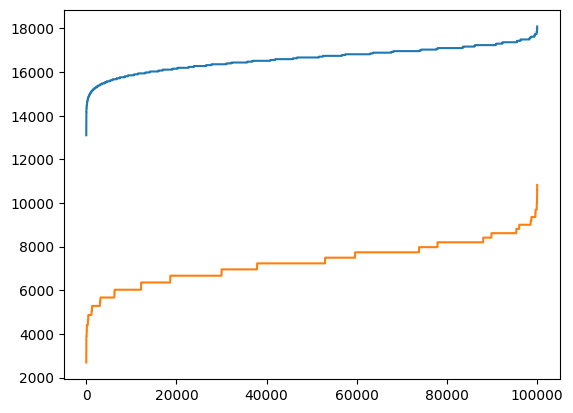

In [38]:
plt.plot(jnp.sort(estimates_100k_pre))
plt.plot(jnp.sort(estimates_100k))
plt.show()

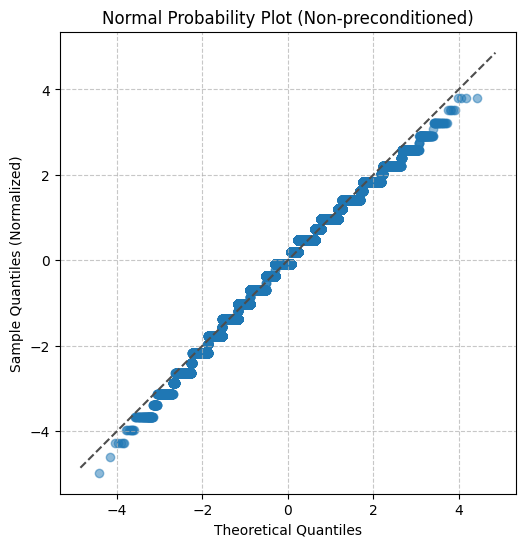

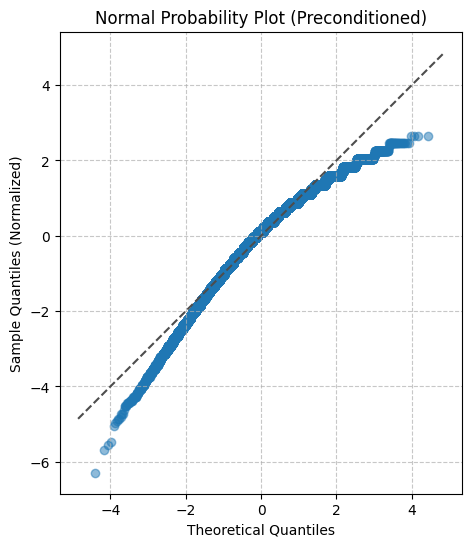

In [51]:
# For the non-preconditioned estimates
fig, ax = normal_probability_plot(estimates_100k, title="Normal Probability Plot (Non-preconditioned)")
# aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# For the preconditioned estimates
fig, ax = normal_probability_plot(estimates_100k_pre, title="Normal Probability Plot (Preconditioned)")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [59]:
# skewness of estimates

print(stats.skew(estimates_100k))
print(stats.skew(estimates_100k_pre))
print(stats.skew(jax.random.normal(jax.random.key(cfg.seed), (100, 100000)), axis=1).std())

-0.2385307401418686
-0.6633809804916382
0.0072959809006911385


In [32]:
# 300
jnp.mean(estimates_300_pre), jnp.max(estimates_300_pre), jnp.min(estimates_300_pre), aggregate(estimates_300_pre)

(Array(16632.787, dtype=float32),
 Array(18091.373, dtype=float32),
 Array(14644.153, dtype=float32),
 Array(18085.67, dtype=float32))

In [33]:
jnp.sort(estimates_300_pre)[-10:] / jnp.log(10), aggregate(estimates_300_pre) / jnp.log(10)

(Array([7543.051 , 7571.091 , 7571.091 , 7598.7593, 7598.7593, 7598.7593,
        7598.7593, 7598.7593, 7653.0205, 7856.984 ], dtype=float32),
 Array(7854.507, dtype=float32))

In [34]:
jnp.sort(estimates_300)[-10:] / jnp.log(10), aggregate(estimates_300) / jnp.log(10)

(Array([3910.1133, 3910.1133, 3910.1133, 3910.1133, 3988.9512, 4064.9219,
        4064.9219, 4064.9219, 4209.045 , 4343.8633], dtype=float32),
 Array(4341.3857, dtype=float32))

In [38]:
param_dim = final_params.raveled.shape[0]

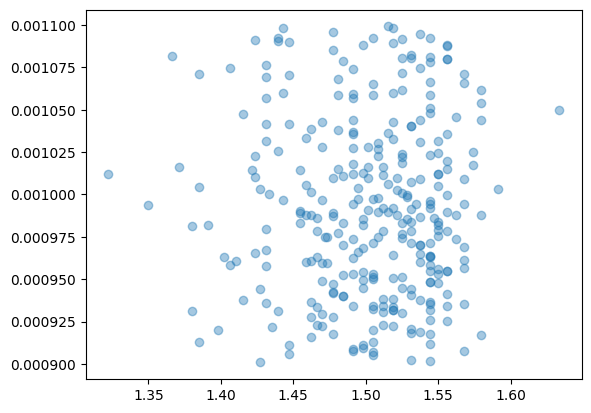

In [39]:
plt.scatter(estimates_300_pre / param_dim / jnp.log(10), diffs_300_pre, alpha=0.4)
plt.show()

In [43]:
jnp.linalg.slogdet(P).logabsdet / jnp.log(10)

Array(5.1438727, dtype=float32)

## logspace indices tests

In [339]:

print(logspace_indices(1000, 10), 999-logspace_indices(1000, 10))
print(logspace_indices(1000, 9), 999-logspace_indices(1000, 9))
print(logspace_indices(999, 10))
print(logspace_indices(999, 9))
print(logspace_indices(998, 10))
print(logspace_indices(998, 9))

[  0   2  11  40 143 499 894 977 995 999] [999 997 988 959 856 500 105  22   4   0]
[  0   3  21 104 499 894 977 995 999] [999 996 978 895 500 105  22   4   0]
[  0   2  11  40 143 498 893 976 994 998]
[  0   3  21 104 498 893 976 994 998]
[  0   2  11  40 143 498 892 975 993 997]
[  0   3  21 104 498 892 975 993 997]


## LR scan

In [ ]:
for lr in logspace(.05, .07, 10):
    cfg = SimpleConfig(train_size=1024, opt="adam", lr=lr)
    test_loss, train_loss, state = quick_train()
    print(f"lr: {lr}, test_loss: {test_loss}, train_loss: {train_loss}")
for lr in logspace(.5, .6, 10):
    cfg = SimpleConfig(train_size=1024, opt="sgd", lr=lr)
    test_loss, train_loss, state = quick_train()
    print(f"lr: {lr}, test_loss: {test_loss}, train_loss: {train_loss}")